In [1]:
from __future__ import division, print_function, absolute_import
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [2]:
# import MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# parameters
learning_rate = 1e-3
num_steps = 30000
batch_size = 64

image_dim = 784 # mnist images are 28*28 pixels
hidden_dim = 512
latent_dim = 2

# a custom initialization (see Xavier glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0]/2.))

In [4]:
# variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}

biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [5]:
# building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# sampler: Normal(gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# building the decoder(with scope to reuse these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [6]:
# definr vae loss
def vae_loss(x_reconstructed, x_true):
    # reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    # kl divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [7]:
# start training 
# start a new tensorflow session
sess = tf.Session()
# run the initializer
sess.run(init)

# training
for i in range(1, num_steps+1):
    batch_x, _ = mnist.train.next_batch(batch_size)
    
    feed_dict = {input_image: batch_x}
    _, loss = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i ==0:
        print('Step %i, Loss: %f' %(i, loss))

Step 1000, Loss: 186.997620
Step 2000, Loss: 152.907913
Step 3000, Loss: 178.876617
Step 4000, Loss: 165.202362
Step 5000, Loss: 166.990723
Step 6000, Loss: 157.756149
Step 7000, Loss: 148.906815
Step 8000, Loss: 164.102097
Step 9000, Loss: 160.288177
Step 10000, Loss: 162.438950
Step 11000, Loss: 153.938828
Step 12000, Loss: 155.329285
Step 13000, Loss: 145.356186
Step 14000, Loss: 148.175491
Step 15000, Loss: 153.517868
Step 16000, Loss: 169.021088
Step 17000, Loss: 151.775085
Step 18000, Loss: 146.943085
Step 19000, Loss: 148.169540
Step 20000, Loss: 151.562439
Step 21000, Loss: 150.349365
Step 22000, Loss: 144.333130
Step 23000, Loss: 155.156372
Step 24000, Loss: 139.507645
Step 25000, Loss: 152.130981
Step 26000, Loss: 146.469864
Step 27000, Loss: 142.854507
Step 28000, Loss: 152.243561
Step 29000, Loss: 146.284286
Step 30000, Loss: 143.926712


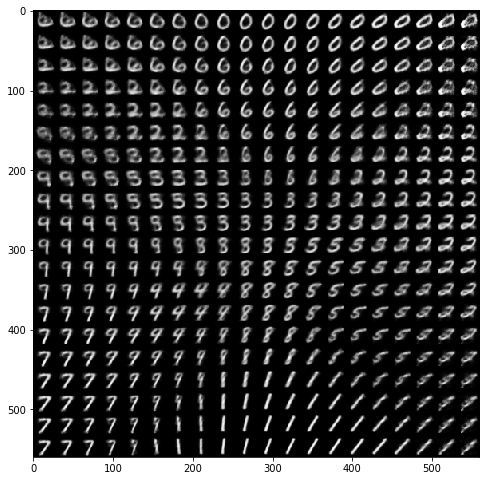

In [9]:
# testing 
# generator takes noise as input
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])

# rebuild the decoder to create image from noise
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

# building a manifold of generated digits
n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28*n, 28*n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i -1) * 28 : (n - i) * 28, j * 28 : (j + 1) * 28] = \
        x_mean[0].reshape(28, 28)
plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()